# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
"import libraries, and define functions for accuracy, confusion matrix, and image display"
%matplotlib inline
import numpy as np # numpy is a library for numerical computing
import matplotlib.pyplot as plt
import seaborn as sns # seaborn is a statistical data visualization library
import torch # PyTorch is a deep learning framework
from torch import nn # nn module contains neural network layers and functions
import torch.nn.functional as F # functional module contains activation functions and loss functions
import torch.optim as optim # optim module contains optimization algorithms
from torch.utils.data import TensorDataset, DataLoader # utilities for data handling
import torchvision # torchvision is a package for computer vision
import torchvision.transforms as transforms # transforms module contains image transformation functions
from torchvision.utils import make_grid # utility to create a grid of images
from sklearn import metrics # scikit-learn is a machine learning library

sns.set_style("whitegrid") # set seaborn style for plots

# Define accuracy function between target and predicted labels
def accuracy(target, pred):
    # where target.detach().cpu().numpy() converts the target tensor to a numpy array
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

# Define function to compute confusion matrix between target and predicted labels
# confusion matrix is a table used to describe the performance of a classification model
def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )
# Define function to display an image tensor
def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
"Load datasets for training and testing, and create data loaders"
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets for training and testing, and create data loaders
# train_set and test_set are instances of CIFAR10
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Create data loaders is used to load data in batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
"print dataset information for training and testing"

print("Training data")
print("Number of points:", len(train_set)) # total number of training samples here is 50000
x, y = next(iter(train_loader)) # get a batch of training data, where x is the images and y is the labels
print("Batch dimension (B x C x H x W):", x.shape) # shape of x image (B=batch size, C=channels, H=height, W=width) => (64, 3, 32, 32)
# there are 10 distinct labels in CIFAR-10 dataset for training as well from 0 to 9
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set)) # total number of test samples here is 10000
x, y = next(iter(test_loader)) # get a batch of test data, where x is the images and y is the labels
print("Batch dimension (B x C x H x W):", x.shape) # shape of x image (B=batch size, C=channels, H=height, W=width) => (64, 3, 32, 32)
# there are 10 distinct labels in CIFAR-10 dataset for testing as well from 0 to 9
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

# Number of classes test set (targets)
n_classes = len(set(test_set.targets))
print(f"\nNumber of classes: {n_classes}") # there are 10 classes in CIFAR-10 dataset

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Number of classes: 10


### Show example images

Run multiple times to see different examples.

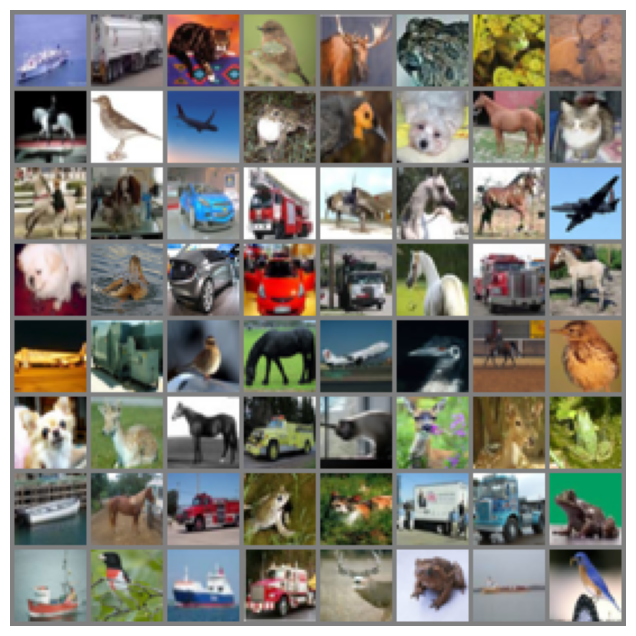

In [4]:
"show some random training images from the training loader"
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [4]:
" define the CNN model."
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Feature extractor: 3 Conv2d layers with BatchNorm, ReLU, and MaxPool2d
        self.features = nn.Sequential(
         # Layer 1: Conv2d -> BatchNorm2d -> ReLU -> MaxPool2d
         nn.Conv2d(3, 64, kernel_size=3, padding=1),
         nn.BatchNorm2d(64),
         nn.ReLU(inplace=True),
         nn.MaxPool2d(2),         # 32 -> 16

         nn.Conv2d(64, 128, kernel_size=3, padding=1),
         nn.BatchNorm2d(128),
         nn.ReLU(inplace=True),
         nn.MaxPool2d(2),         # 16 -> 8

         nn.Conv2d(128, 256, kernel_size=3, padding=1),
         nn.BatchNorm2d(256),
         nn.ReLU(inplace=True),
         nn.MaxPool2d(2),         # 8 -> 4

        PrintSize(),
 )
       
        # Compute flattened feature size dynamically using a dummy forward.
        # This avoids hard-coding channels * H * W and keeps code robust.
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 32, 32)
            feat = self.features(dummy)
            n_features = feat.view(1, -1).size(1)

        # Classification head using the pattern you suggested:
        # Flatten -> Linear(n_features, 128) -> ReLU -> Linear(128, 128) -> ReLU -> Linear(128, num_classes)
        # n_features is the flattened size after the feature extractor: channels * height * width
        
        self.classifier = nn.Sequential(
            nn.Flatten(),# Flatten the feature maps
            nn.Linear(n_features, 128),# Linear layer from n_features as input to 128 is output
            nn.ReLU(inplace=True),# Activation function
            nn.Linear(128, 128), # Second linear layer from 128 as input to 128 is output
            nn.ReLU(inplace=True),# Activation function
            nn.Linear(128, num_classes), # output layer from 128 as input to num_classes is output
        )
    # forward pass of the model
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# create an instance of the model and move it to the appropriate device
model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)


Size: torch.Size([1, 256, 4, 4])
Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): PrintSize()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [5]:
"define loss function and optimizer"
loss_fn = nn.CrossEntropyLoss()  # <- Your code here!
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # <- Your code here!


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [6]:
" Test the forward pass with dummy data"

# Create a batch of random input data
# (2, 3, 32, 32) where 2 is the batch size, 3 is the number of channels, and 32x32 is the image size
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size()) # should be (2, 10) where 2 is the batch size, and 10 is the number of classes
# Print the output logits is the raw scores before applying softmax
print(f"Output logits:\n{out.detach().cpu().numpy()}") 
# Print the output probabilities after applying softmax
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.06801204  0.04712371 -0.02864946 -0.05677786 -0.06130847 -0.04707412
   0.04203147 -0.0559927  -0.08892925 -0.04525448]
 [-0.01153415  0.1203861  -0.06918716 -0.04985112 -0.05672939 -0.05411825
   0.07949333 -0.0524371  -0.07788294 -0.03213463]]
Output probabilities:
[[0.09678581 0.10859618 0.10067153 0.09787925 0.09743681 0.09883367
  0.10804459 0.09795614 0.09478235 0.09901368]
 [0.10068304 0.11488109 0.09504252 0.09689815 0.09623394 0.09648555
  0.11027804 0.0966479  0.09421963 0.09863015]]


In [7]:
"compute training and validation accuracies"
#num_epochs = 2 # number of epochs to train
num_epochs = 64 # number of epochs to train
validation_every_steps = 500 # validate every 500 training steps

step = 0 # initialize step counter
model.train() # set model to training mode
# Initialize lists to store training and validation accuracies
train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    " Compute accuracies on training set"
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        # forward pass: get the model output
        output = model(inputs)
        # Compute loss. based on output model and targets
        loss = loss_fn(output, targets)
        #  # Clean up gradients from the model.
        optimizer.zero_grad()
        #Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()

         # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()

        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            " Compute accuracies on validation set."
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    # forward pass: get the model output
                    output = model(inputs)
                    # Compute loss. based on output model and targets
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")

print("Finished training.")


Step 500     training accuracy: 0.53190625
             validation accuracy: 0.6189
Step 1000    training accuracy: 0.6950974770642202
             validation accuracy: 0.6739
Step 1500    training accuracy: 0.728625
             validation accuracy: 0.742
Step 2000    training accuracy: 0.7694954128440367
             validation accuracy: 0.7215
Step 2500    training accuracy: 0.8104707792207793
             validation accuracy: 0.7308
Step 3000    training accuracy: 0.80609375
             validation accuracy: 0.7688
Step 3500    training accuracy: 0.8368195564516129
             validation accuracy: 0.7718
Step 4000    training accuracy: 0.8711805555555555
             validation accuracy: 0.787
Step 4500    training accuracy: 0.8650625
             validation accuracy: 0.7807
Step 5000    training accuracy: 0.8912844967532467
             validation accuracy: 0.774
Step 5500    training accuracy: 0.9158653846153846
             validation accuracy: 0.7967
Step 6000    training accu

KeyboardInterrupt: 

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

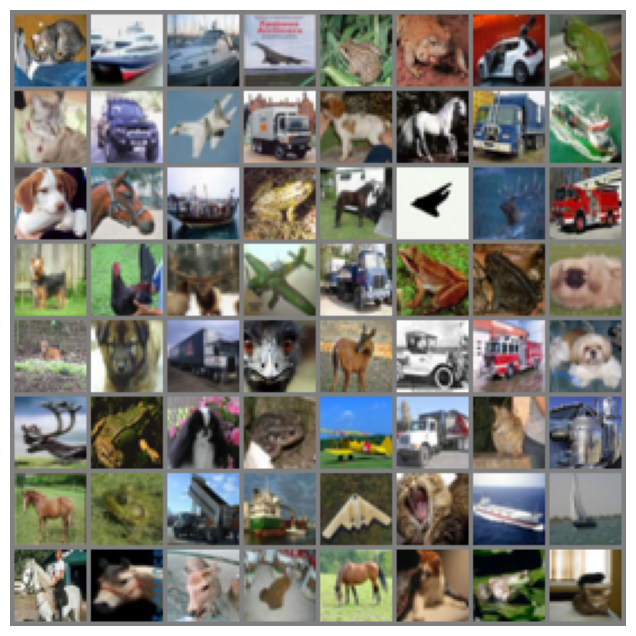

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship       automobile  
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           cat     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane        bird     
    deer          deer     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          bird     
     dog           d

In [8]:
"make predictions on some test images"
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

# forward pass, get model outputs
outputs = model(inputs)
# make predictions
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [9]:
"Evaluate test set"
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():# no gradients needed for test evaluation
    model.eval() # model in evaluation mode
    test_accuracies = [] # list to store accuracies for each batch
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # forward pass: get the model output
        output = model(inputs)
        # compute loss. based on output model and targets
        loss = loss_fn(output, targets)
        # make predictions based on model output
        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        # construct confusion matrix between targets and predictions
        confusion_matrix += compute_confusion_matrix(targets, predictions)
      # test_accuracy is the overall accuracy on the test set divided by number of test samples
    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [10]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.791


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


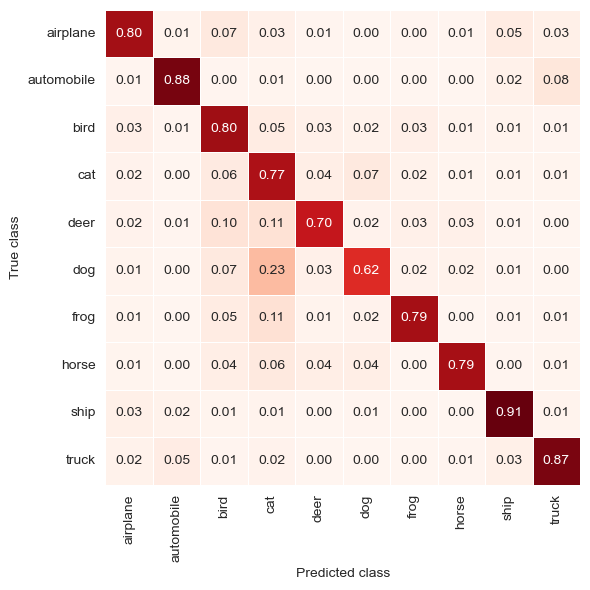

In [11]:
" make a normalized confusion matrix plot"
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

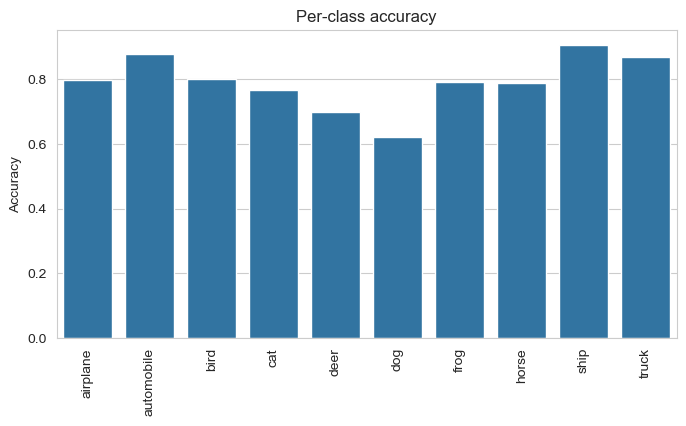

In [12]:
" the diagonal and plot the numbers in a bar plot, make a class accuracy bar plot"
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.